In [63]:
#Librerias necesarias
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm

---
# Inicio
## Cargamos el dataset

In [64]:
#Cargamos el dataset limpio del TP 1
data = pd.read_csv('dataset_caba.csv')
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.rename(columns={'place_name_normalized':'place', 'property_type':'ptype'}, inplace=True)
data.sample(3)

ptype     price  surface_total_in_m2  surface_covered_in_m2  \
689   apartment  125000.0                 72.0                   72.0   
82    apartment   82000.0                 56.0                   47.0   
1729         PH  155000.0                 85.0                   85.0   

      price_usd_per_m2  floor  rooms          place disposicion  aEstrenar  \
689        1736.111111    3.0    2.0   Villa Crespo      frente          0   
82         1464.285714    0.0    2.0          Nuñez      frente          0   
1729       1823.529412    4.0    3.0  San Cristóbal      frente          0   

      garage  balcon  piscina  sum  patio  lavadero  amenities  parrilla  
689        0       0        0    0      1         1          0         0  
82         1       0        1    1      1         0          1         1  
1729       0       1        0    0      0         1          0         1

---
# Modelo
Este modelo solo utiliza las columnas básicas del dataset: ptype, floor y rooms

In [68]:
y_columnas = ['price_usd_per_m2']
x_columnas = ['ptype','floor','rooms']
data_modelo =  pd.concat([data[y_columnas],data[x_columnas]], axis = 1)
data_modelo.sample(3)

price_usd_per_m2      ptype  floor  rooms
2252       2200.000000  apartment    0.0    2.0
4221       1706.666667  apartment    7.0    3.0
3350       2142.857143  apartment    1.0    3.0

### Análisis correlación

In [69]:
#Análisis de correlación entre variables
data_modelo.corr()

price_usd_per_m2     floor     rooms
price_usd_per_m2          1.000000  0.058369 -0.144575
floor                     0.058369  1.000000  0.033199
rooms                    -0.144575  0.033199  1.000000

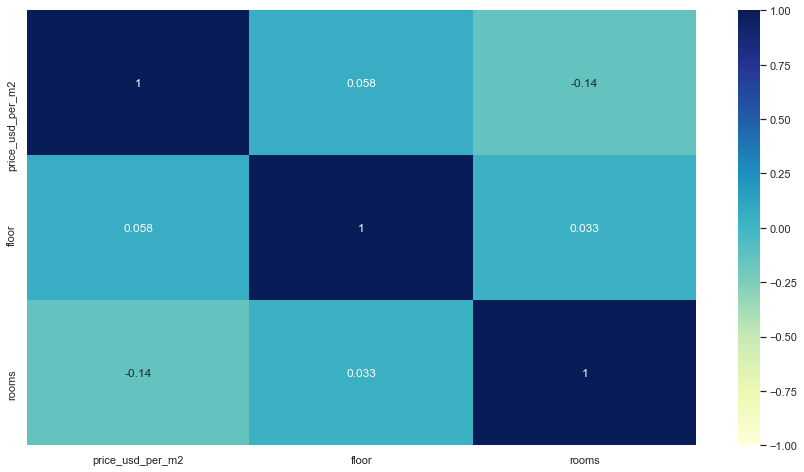

In [70]:
# visualizamos la matriz de correlación en Seaborn usando a heatmap
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data_modelo.corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu",annot=True);

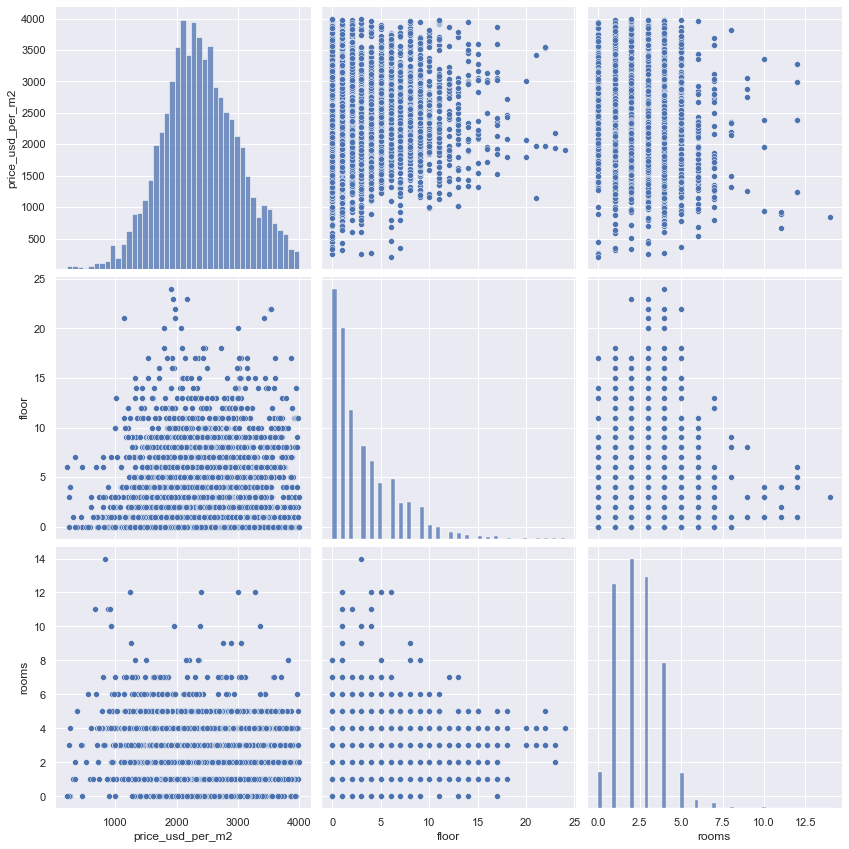

In [71]:
sns.pairplot(data=data_modelo, height=4)

In [72]:
name_model="Modelo 1" #Cambiar este nombre para cambiar los resultados de los estadísticos de cada algoritmo

## Pre-Training
### Manejo variables categóricas
Modificar las variables que deban ser dumificadas

In [85]:
#Creo dummies
#Convierto floor a object
data_modelo['floor'] = data_modelo['floor'].astype(np.object)
data_dummies=pd.get_dummies(data_modelo[['ptype','floor']], drop_first = True)
data_dummies

ptype_apartment  ptype_house  floor_1.0  floor_2.0  floor_3.0  \
0                   1            0          0          0          1   
1                   1            0          0          1          0   
2                   1            0          1          0          0   
3                   1            0          1          0          0   
4                   1            0          0          0          0   
...               ...          ...        ...        ...        ...   
6397                1            0          0          1          0   
6398                1            0          0          0          0   
6399                1            0          1          0          0   
6400                1            0          1          0          0   
6401                1            0          1          0          0   

      floor_4.0  floor_5.0  floor_6.0  floor_7.0  floor_8.0  ...  floor_14.0  \
0             0          0          0          0          0  ...           0   
1             0          0          0          0          0  ...           0   
2             0          0          0          0          0  ...           0   
3             0          0          0          0          0  ...           0   
4             0          0          0          0          0  ...           0   
...         ...        ...        ...        ...        ...  ...         ...   
6397          0          0          0          0          0  ...           0   
6398          1          0          0          0          0  ...           0   
6399          0          0          0          0          0  ...           0   
6400          0          0          0          0          0  ...           0   
6401          0          0          0          0          0  ...           0   

      floor_15.0  floor_16.0  floor_17.0  floor_18.0  floor_20.0  floor_21.0  \
0              0           0           0           0           0           0   
1              0           0           0           0           0           0   
2              0           0           0           0           0           0   
3              0           0           0           0           0           0   
4              0           0           0           0           0           0   
...          ...         ...         ...         ...         ...         ...   
6397           0           0           0           0           0           0   
6398           0           0           0           0           0           0   
6399           0           0           0           0           0           0   
6400           0           0           0           0           0           0   
6401           0           0           0           0           0           0   

      floor_22.0  floor_23.0  floor_24.0  
0              0           0           0  
1              0           0           0  
2              0           0           0  
3              0           0           0  
4              0           0           0  
...          ...         ...         ...  
6397           0           0           0  
6398           0           0           0  
6399           0           0           0  
6400           0           0           0  
6401           0           0           0  

[6402 rows x 25 columns]

In [86]:
#Concateno las columnas que están por fuera del dummie
columnas=['price_usd_per_m2','rooms']
data_modelo = pd.concat([data[columnas],data_dummies], axis = 1)
data_modelo = data_modelo.reset_index(drop=True)
data_modelo.head(3)

price_usd_per_m2  rooms  ptype_apartment  ptype_house  floor_1.0  \
0       1309.090909    2.0                1            0          0   
1       1812.500000    4.0                1            0          0   
2       1702.127660    5.0                1            0          1   

   floor_2.0  floor_3.0  floor_4.0  floor_5.0  floor_6.0  ...  floor_14.0  \
0          0          1          0          0          0  ...           0   
1          1          0          0          0          0  ...           0   
2          0          0          0          0          0  ...           0   

   floor_15.0  floor_16.0  floor_17.0  floor_18.0  floor_20.0  floor_21.0  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   

   floor_22.0  floor_23.0  floor_24.0  
0           0           0           0  
1           0           0           0  
2           0           0           0  

[3 rows x 27 columns]

## Algoritmos

In [87]:
#Genero mi variable X
X=data_modelo.drop(['price_usd_per_m2'],axis=1)

#Genero la variable y
y = data_modelo[y_columnas].squeeze()

#Creamos las muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100,shuffle=True)

### Linear Regression

In [88]:
#Entrenamos modelo LR
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
#Predecimos
lr_prediction = model_lr.predict(X_test)
lr_prediction_train = model_lr.predict(X_train)

intercept_lr = model_lr.intercept_
coeff_lr = model_lr.coef_
r2_test_lr = model_lr.score(X_test, y_test)
r2_train_lr = model_lr.score(X_train, y_train)
n = len(y_test)
p = np.count_nonzero(coeff_lr)
r2_adj_test_lr = 1-((1-r2_test_lr)*((len(y_test)-1)/(len(y_test)-p-1)))
r2_adj_train_lr = 1-((1-r2_train_lr)*((len(y_train)-1)/(len(y_train)-p-1)))
mse_test_lr = mean_squared_error(y_test, lr_prediction)
mse_train_lr = mean_squared_error(y_train, lr_prediction_train)
mae_test_lr = mean_absolute_error(y_test, lr_prediction)
mae_train_lr = mean_absolute_error(y_train, lr_prediction_train)
rmse_test_lr = np.sqrt(mse_test_lr)
rmse_train_lr = np.sqrt(mse_train_lr)

#Valores estadísticos MSE Test, MSE Train, MAE Test, MAE Train, RMSE Test, RMSE Train, R2 Test, R2 Train, R2 Adj Test, R2 Adj Train
stats_lr=[mse_test_lr, mse_train_lr,
            mae_test_lr, mae_train_lr, 
            rmse_test_lr,rmse_train_lr,
            r2_test_lr,r2_train_lr,
            r2_adj_test_lr,r2_adj_train_lr
         ]

stats_dataframe_lr=pd.DataFrame({name_model+' LR':stats_lr},index=['MSE Test', 'MSE Train', 'MAE Test', 'MAE Train', 'RMSE Test', 'RMSE Train', 'R2 Test','R2 Train', 'R2 Adj Test','R2 Adj Train'])
stats_dataframe_lr

Modelo 1 LR
MSE Test      371723.501230
MSE Train     373533.040781
MAE Test         485.846900
MAE Train        485.676851
RMSE Test        609.691316
RMSE Train       611.173495
R2 Test            0.028154
R2 Train           0.038095
R2 Adj Test        0.015333
R2 Adj Train       0.032697

In [89]:
print("Intercept:", intercept_lr)
print("Coeficientes:")
print(print(pd.Series(coeff_lr, index=X.columns)))

Intercept: 2339.289989916333
Coeficientes:
rooms              -59.029881
ptype_apartment    207.820572
ptype_house         79.368112
floor_1.0         -106.701721
floor_2.0          -33.910793
floor_3.0          -16.074098
floor_4.0          -10.451997
floor_5.0           37.007355
floor_6.0           58.730653
floor_7.0          -59.670158
floor_8.0          137.692949
floor_9.0         -114.884109
floor_10.0          42.223851
floor_11.0         273.863706
floor_12.0         132.350700
floor_13.0         -29.684963
floor_14.0         226.177828
floor_15.0         202.015270
floor_16.0         512.480623
floor_17.0          86.619411
floor_18.0         -42.182091
floor_20.0         -63.622245
floor_21.0        -402.807804
floor_22.0         821.062513
floor_23.0        -435.238310
floor_24.0           0.000000
dtype: float64
None


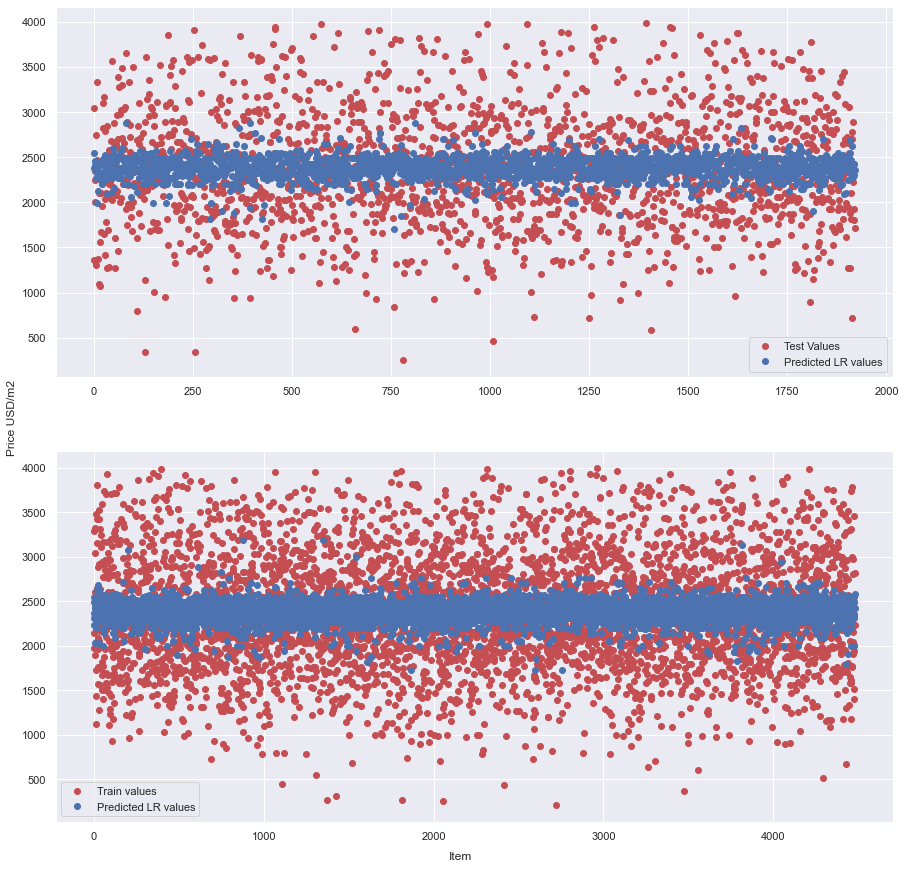

In [90]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],lr_prediction, 'bo', label="Predicted LR values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],lr_prediction_train, 'bo', label="Predicted LR values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Price USD/m2', va='center', rotation='vertical')
plt.show()

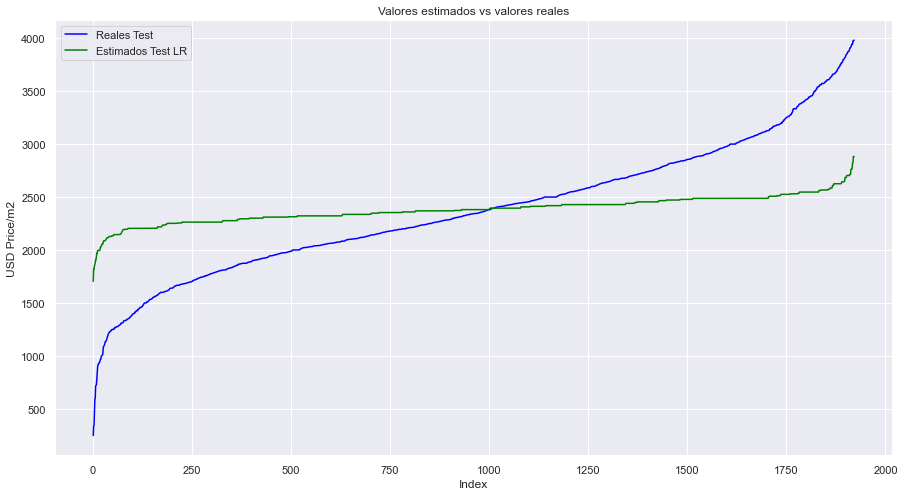

In [91]:
eje_X=range(1,len(y_test)+1)
plt.plot(eje_X, sorted(y_test), color='blue', label='Reales Test')
plt.plot(eje_X, sorted(lr_prediction), color='green', label='Estimados Test LR')
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('USD Price/m2')
plt.show()

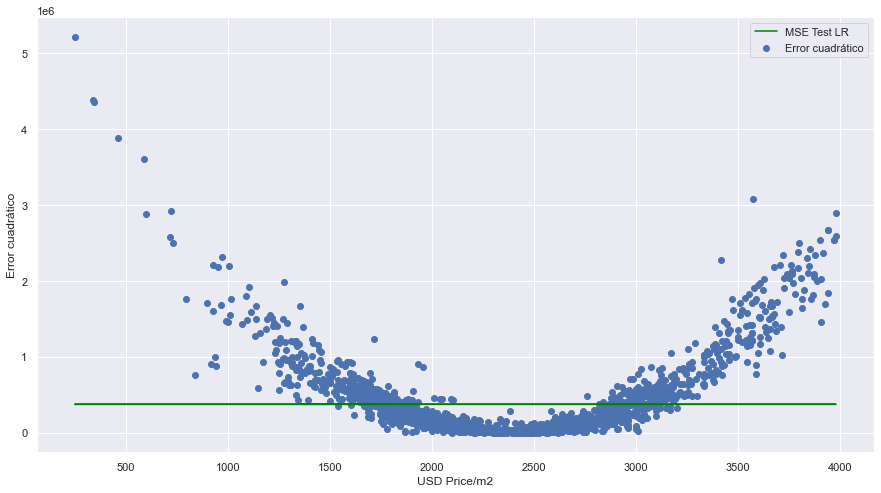

In [92]:
#Qué tan alejados están los valores del error cuadrático medio MSE TEST
err_cuad_test_lr=pow(y_test - lr_prediction,2)
plt.scatter(y_test,err_cuad_test_lr, label='Error cuadrático')
plt.plot(y_test,np.repeat(mse_test_lr,len(err_cuad_test_lr)), label='MSE Test LR', color='green')
plt.legend()
plt.xlabel('USD Price/m2')
plt.ylabel('Error cuadrático')
plt.show()

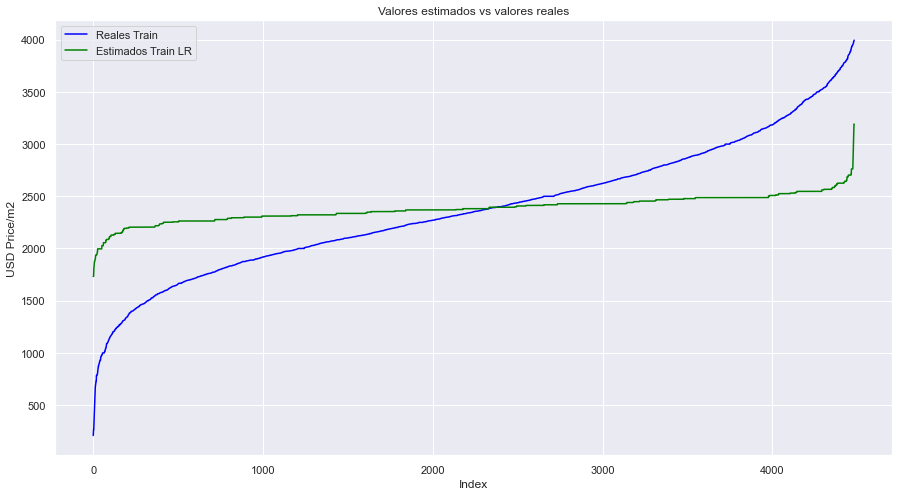

In [93]:
eje_X=range(1,len(y_train)+1)
plt.plot(eje_X, sorted(y_train), color='blue', label='Reales Train')
plt.plot(eje_X, sorted(lr_prediction_train), color='green', label='Estimados Train LR')
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('USD Price/m2')
plt.show()

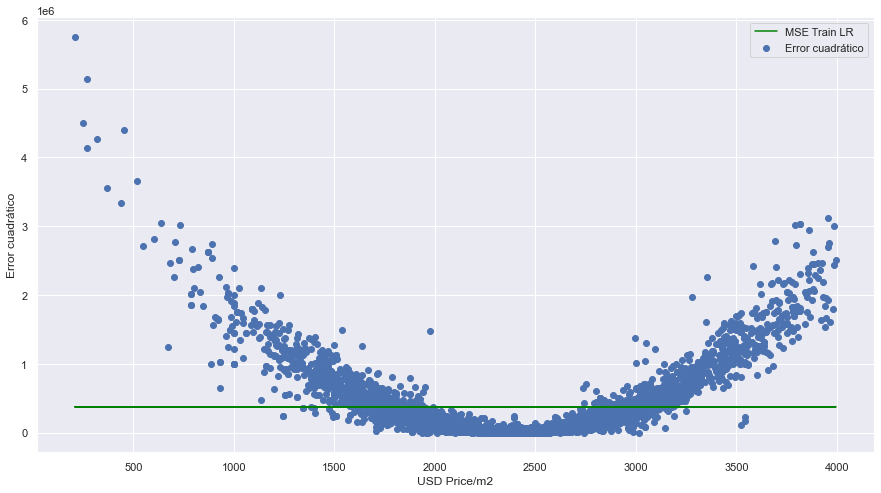

In [94]:
#Qué tan alejados están los valores del error cuadrático medio MSE TRAIN
err_cuad_train_lr=pow(y_train - lr_prediction_train,2)
plt.scatter(y_train,err_cuad_train_lr, label='Error cuadrático')
plt.plot(y_train,np.repeat(mse_train_lr,len(err_cuad_train_lr)), label='MSE Train LR', color='green')
plt.legend()
plt.xlabel('USD Price/m2')
plt.ylabel('Error cuadrático')
plt.show()

Text(0.5, 1.0, 'Residuos del modelo con train')

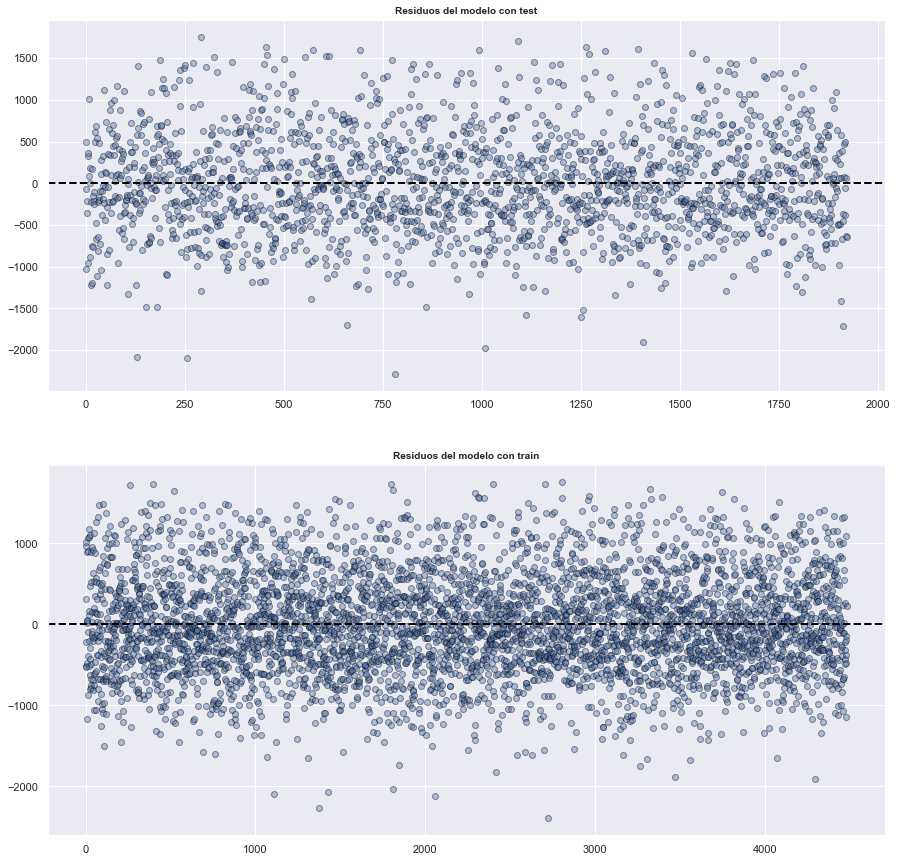

In [95]:
#Gráfico de los residuos/errores
model_residuals_test_lr = y_test - lr_prediction
model_residuals_train_lr = y_train-lr_prediction_train

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].scatter(list(range(len(y_test))), model_residuals_test_lr,
                   edgecolors=(0, 0, 0), alpha = 0.4, c="b")
axes[0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0].set_title('Residuos del modelo con test', fontsize = 10, fontweight = "bold")
axes[1].scatter(list(range(len(y_train))), model_residuals_train_lr,
                   edgecolors=(0, 0, 0), alpha = 0.4, c="b")
axes[1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[1].set_title('Residuos del modelo con train', fontsize = 10, fontweight = "bold")

[Text(0.5, 1.0, 'Residuos con Train')]

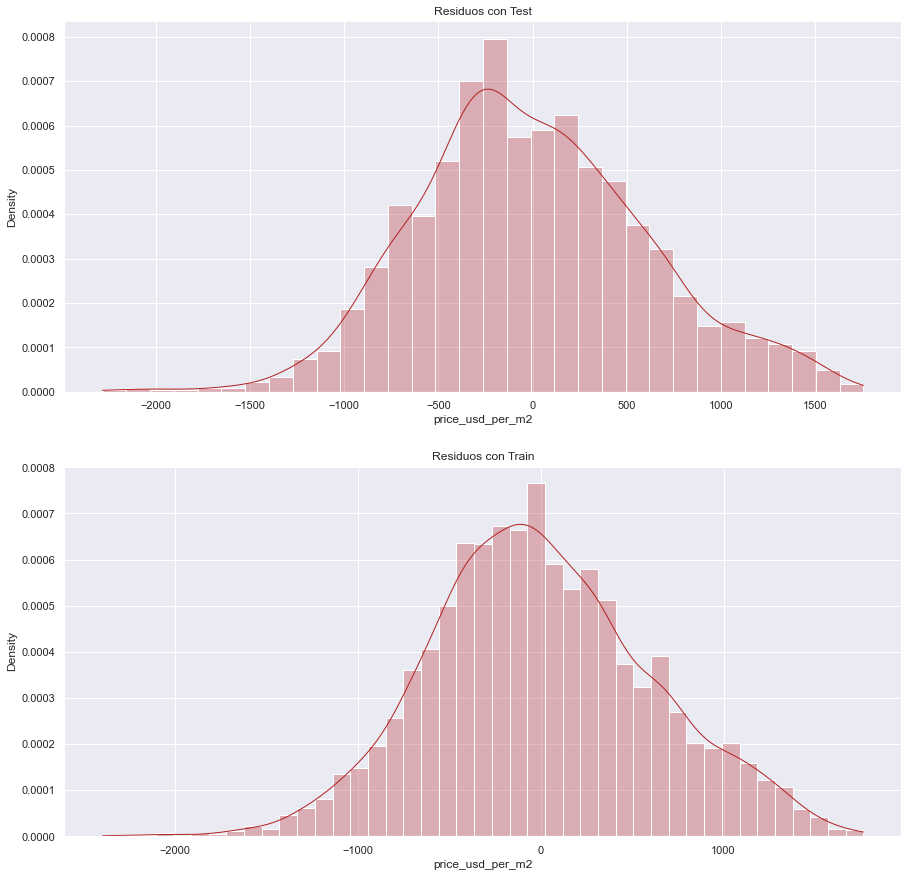

In [96]:
#Residuos en formato histograma
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

sns.histplot(
    data    = model_residuals_test_lr,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[0]
).set(title='Residuos con Test')

sns.histplot(
    data    = model_residuals_train_lr,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1]
).set(title='Residuos con Train')

### OLS

In [97]:
#Entrenamos modelo OLS
X_train_sm = sm.add_constant(X_train)
model_ols = sm.OLS(y_train, X_train_sm).fit()
#Predecimos
X_test_sm = sm.add_constant(X_test)
sm_prediction = model_ols.predict(X_test_sm)
X_train_sm = sm.add_constant(X_train)
sm_prediction_train = model_ols.predict(X_train_sm)

r2_test_ols = r2_score(y_test,sm_prediction)
r2_train_ols = r2_score(y_train,sm_prediction_train)
r2_adj_test_ols = sm.OLS(y_test, X_test_sm).fit().rsquared_adj
r2_adj_train_ols = model_ols.rsquared_adj
mse_test_ols = mean_squared_error(y_test, sm_prediction)
mse_train_ols = mean_squared_error(y_train, sm_prediction_train)
mae_test_ols = mean_absolute_error(y_test, sm_prediction)
mae_train_ols = mean_absolute_error(y_train, sm_prediction_train)
rmse_test_ols = np.sqrt(mse_test_ols)
rmse_train_ols = np.sqrt(mse_train_ols)

#Valores estadísticos MSE Test, MSE Train, MAE Test, MAE Train, RMSE Test, RMSE Train, R2 Test, R2 Train, R2 Adj Test, R2 Adj Train
stats_ols=[mse_test_ols, mse_train_ols,
            mae_test_ols, mae_train_ols, 
            rmse_test_ols,rmse_train_ols,
            r2_test_ols,r2_train_ols,
            r2_adj_test_ols,r2_adj_train_ols
         ]

stats_dataframe_ols=pd.DataFrame({name_model+' OLS':stats_ols},index=['MSE Test', 'MSE Train', 'MAE Test', 'MAE Train', 'RMSE Test', 'RMSE Train', 'R2 Test','R2 Train', 'R2 Adj Test','R2 Adj Train'])

#Summary
print(model_ols.summary())
print("")
print(stats_dataframe_ols)

                            OLS Regression Results                            
Dep. Variable:       price_usd_per_m2   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     7.057
Date:                Sat, 06 Aug 2022   Prob (F-statistic):           3.50e-24
Time:                        16:38:27   Log-Likelihood:                -35106.
No. Observations:                4481   AIC:                         7.026e+04
Df Residuals:                    4455   BIC:                         7.043e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2339.2900     70.176     

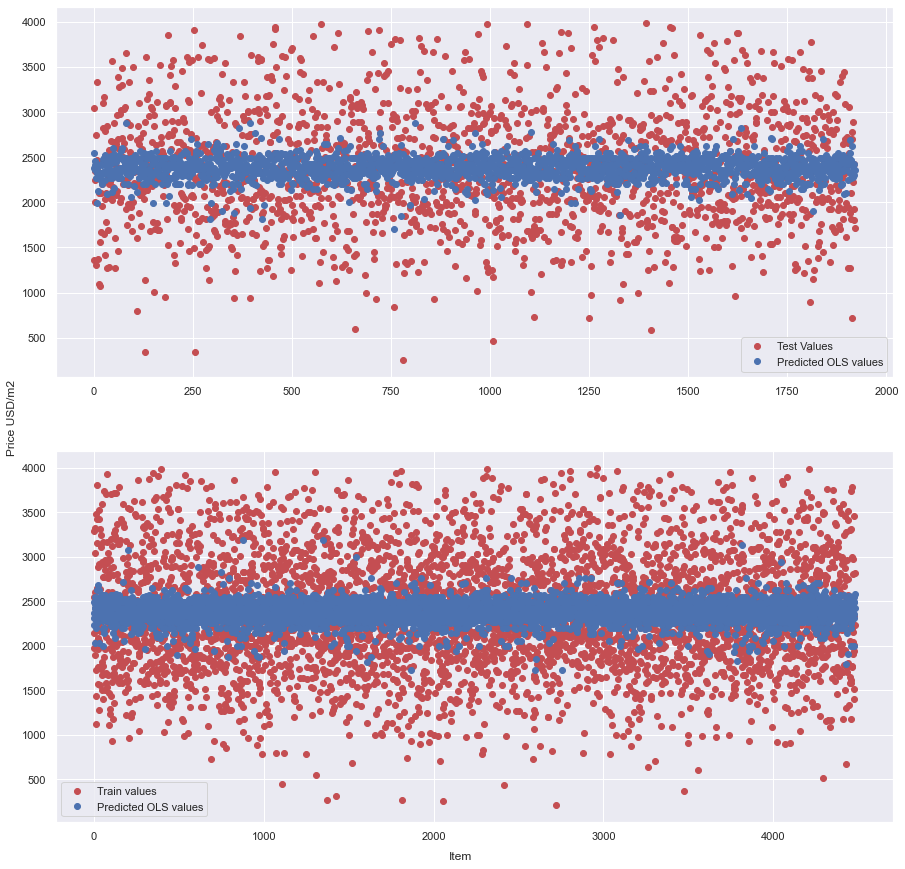

In [98]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],sm_prediction, 'bo', label="Predicted OLS values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],sm_prediction_train, 'bo', label="Predicted OLS values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Price USD/m2', va='center', rotation='vertical')
plt.show()

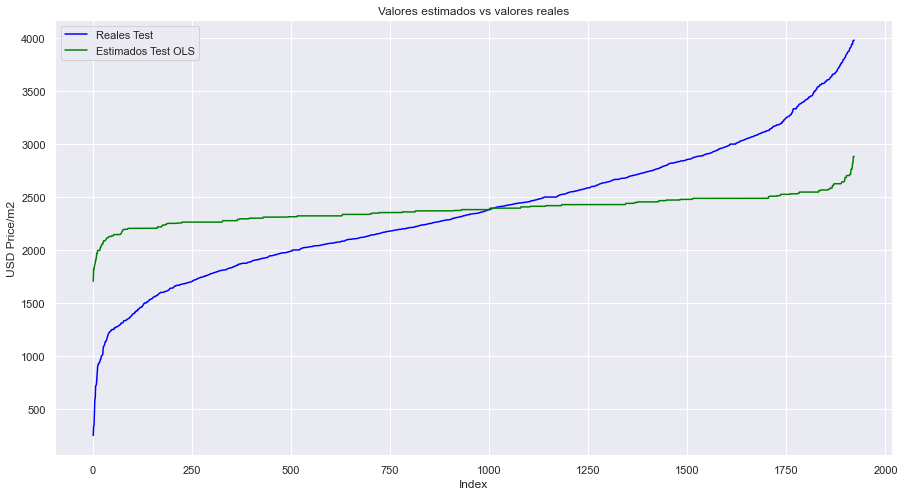

In [99]:
eje_X=range(1,len(y_test)+1)
plt.plot(eje_X, sorted(y_test), color='blue', label='Reales Test')
plt.plot(eje_X, sorted(sm_prediction), color='green', label='Estimados Test OLS')
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('USD Price/m2')
plt.show()

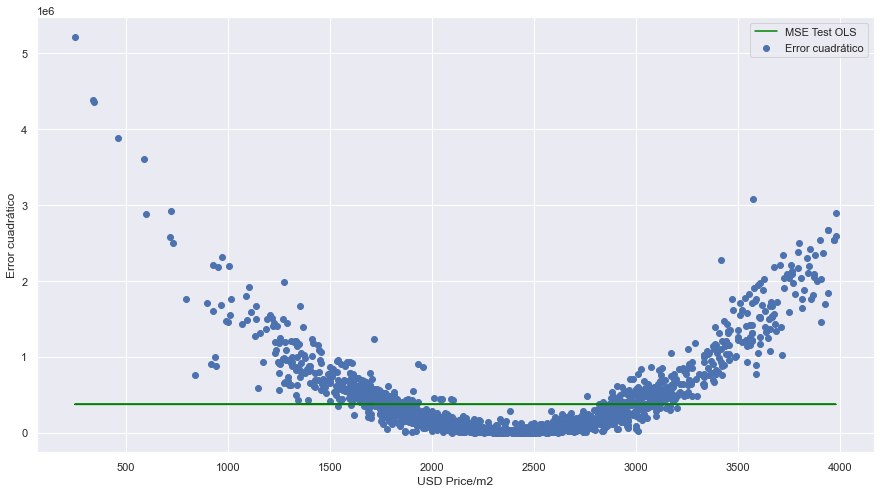

In [100]:
#Qué tan alejados están los valores del error cuadrático medio MSE TEST
err_cuad_test_ols=pow(y_test - sm_prediction,2)
plt.scatter(y_test,err_cuad_test_ols, label='Error cuadrático')
plt.plot(y_test,np.repeat(mse_test_ols,len(err_cuad_test_ols)), label='MSE Test OLS', color='green')
plt.legend()
plt.xlabel('USD Price/m2')
plt.ylabel('Error cuadrático')
plt.show()

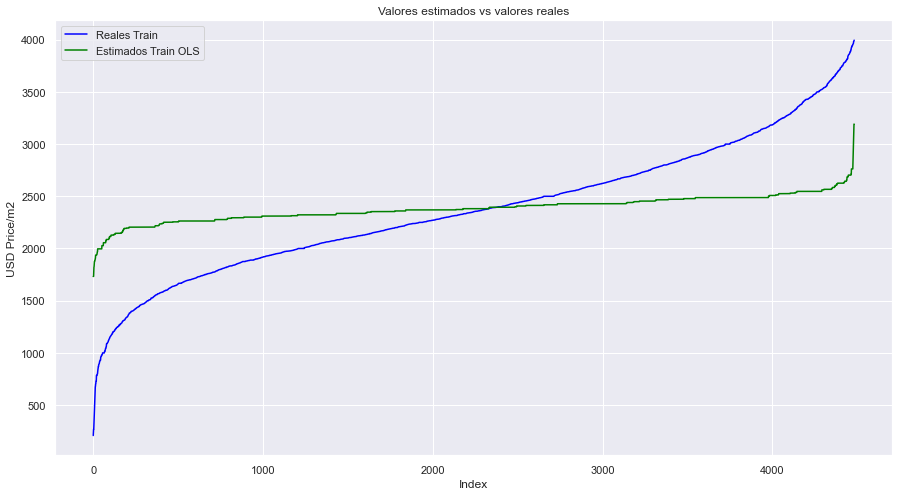

In [101]:
eje_X=range(1,len(y_train)+1)
plt.plot(eje_X, sorted(y_train), color='blue', label='Reales Train')
plt.plot(eje_X, sorted(sm_prediction_train), color='green', label='Estimados Train OLS')
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('USD Price/m2')
plt.show()

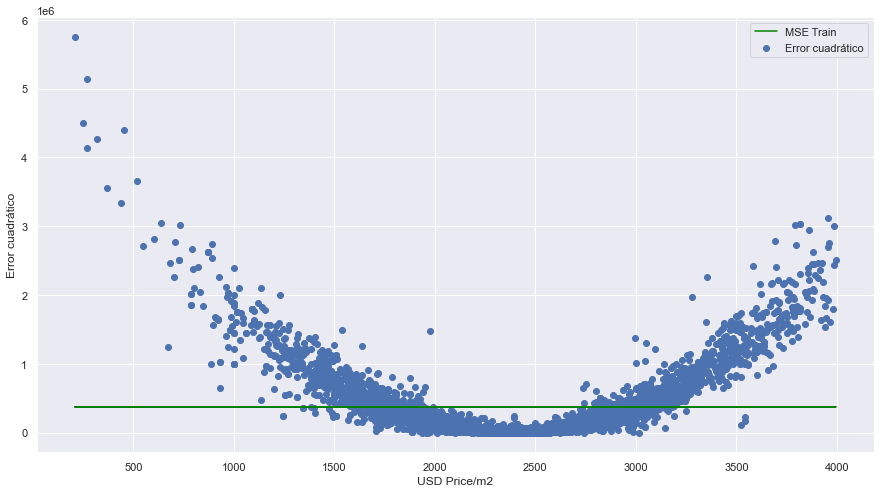

In [102]:
#Qué tan alejados están los valores del error cuadrático medio MSE TRAIN
err_cuad_train_ols=pow(y_train - sm_prediction_train,2)
plt.scatter(y_train,err_cuad_train_ols, label='Error cuadrático')
plt.plot(y_train,np.repeat(mse_train_ols,len(err_cuad_train_ols)), label='MSE Train', color='green')
plt.legend()
plt.xlabel('USD Price/m2')
plt.ylabel('Error cuadrático')
plt.show()

Text(0.5, 1.0, 'Residuos del modelo con train')

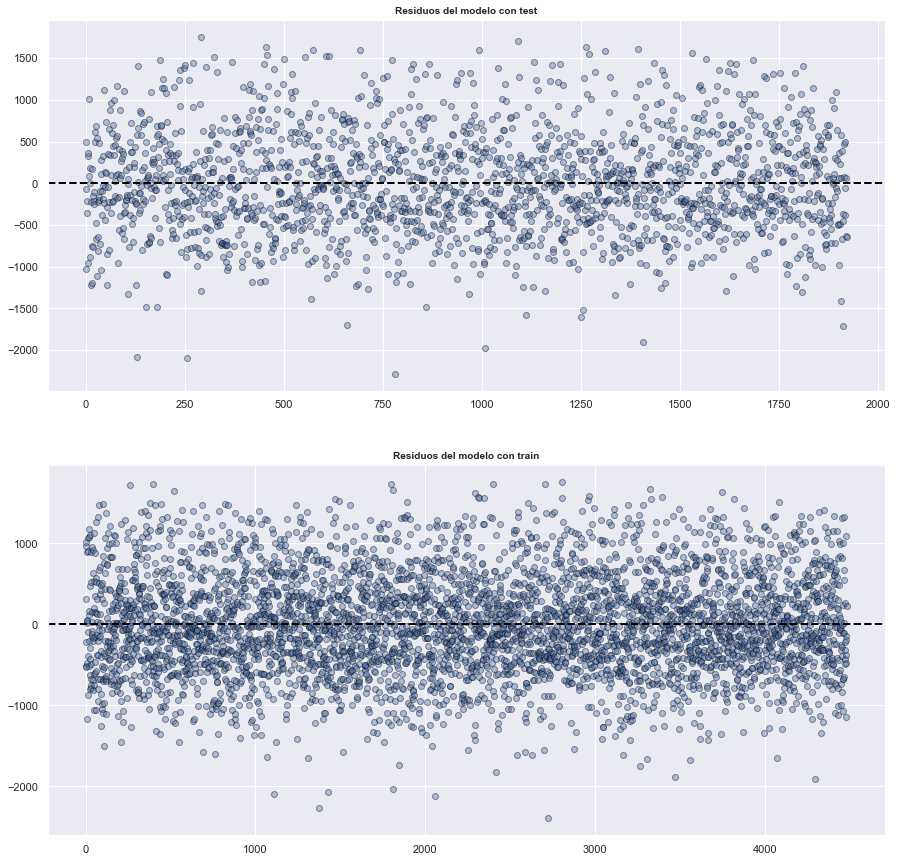

In [103]:
#Gráfico de los residuos/errores
model_residuals_test_ols = y_test - sm_prediction
model_residuals_train_ols = y_train - sm_prediction_train

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].scatter(list(range(len(y_test))), model_residuals_test_ols,
                   edgecolors=(0, 0, 0), alpha = 0.4, c="b")
axes[0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0].set_title('Residuos del modelo con test', fontsize = 10, fontweight = "bold")
axes[1].scatter(list(range(len(y_train))), model_residuals_train_ols,
                   edgecolors=(0, 0, 0), alpha = 0.4, c="b")
axes[1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[1].set_title('Residuos del modelo con train', fontsize = 10, fontweight = "bold")

[Text(0.5, 1.0, 'Residuos con Train')]

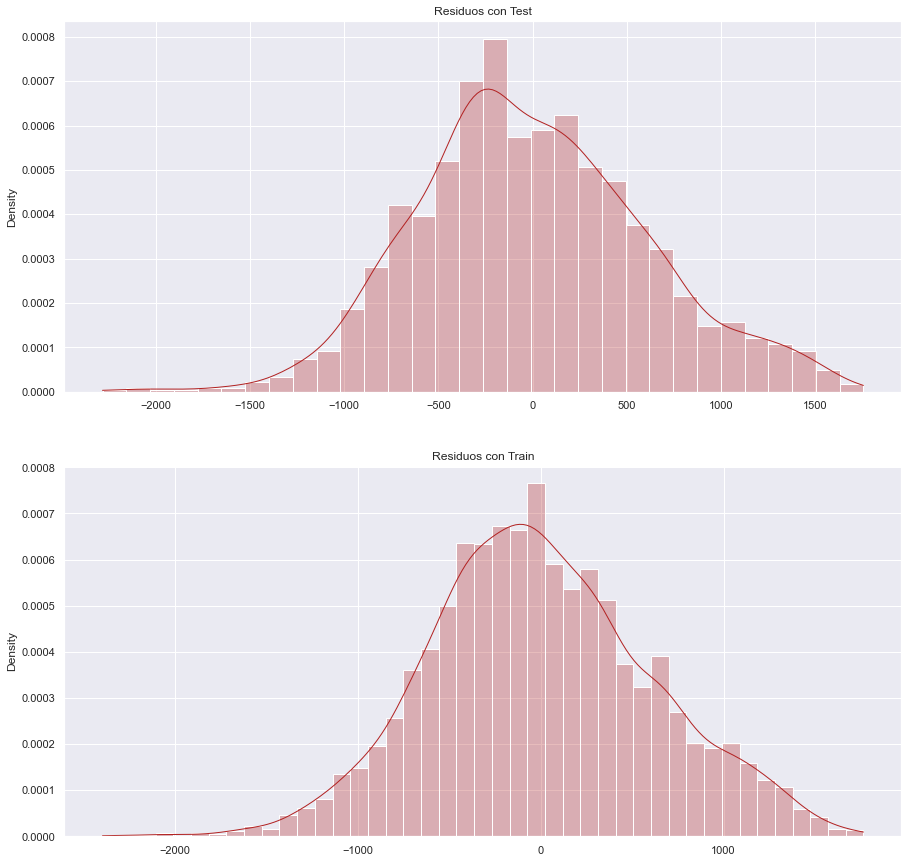

In [104]:
#Residuos en formato histograma
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

sns.histplot(
    data    = model_residuals_test_ols,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[0]
).set(title='Residuos con Test')

sns.histplot(
    data    = model_residuals_train_ols,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1]
).set(title='Residuos con Train')

### LASSO

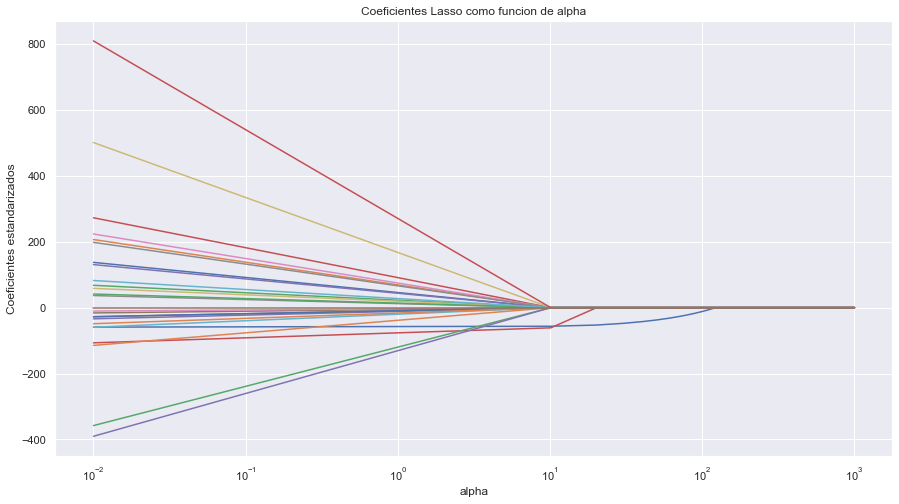

In [105]:
#Análisis previo de los alpha
alphas_lasso = np.linspace(0.01,1000,100)
lasso = linear_model.Lasso(max_iter = 10000, normalize = False)
coefs = []

for a in alphas_lasso:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas_lasso, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coeficientes estandarizados')
plt.title('Coeficientes Lasso como funcion de alpha');

In [106]:
#Creamos el modelo
lassocv = linear_model.LassoCV(alphas=None,normalize=False,cv=10,random_state=10, max_iter=10000)
#Lo entrenamos
model_lasso = lassocv.fit(X_train, y_train)
#Lo probamos
lasso_prediction = model_lasso.predict(X_test)
lasso_prediction_train = model_lasso.predict(X_train)

alpha_lasso = model_lasso.alpha_
coeff_lasso = model_lasso.coef_
intercept_lasso = model_lasso.intercept_
r2_test_lasso = model_lasso.score(X_test, y_test)
r2_train_lasso = model_lasso.score(X_train, y_train)
p = np.count_nonzero(coeff_lasso)
r2_adj_test_lasso = 1-((1-r2_test_lasso)*((len(y_test)-1)/(len(y_test)-p-1)))
r2_adj_train_lasso = 1-((1-r2_train_lasso)*((len(y_train)-1)/(len(y_train)-p-1)))
mse_test_lasso = mean_squared_error(y_test, lasso_prediction)
mse_train_lasso = mean_squared_error(y_train, lasso_prediction_train)
mae_test_lasso = mean_absolute_error(y_test, lasso_prediction)
mae_train_lasso = mean_absolute_error(y_train, lasso_prediction_train)
rmse_test_lasso = np.sqrt(mse_test_lasso)
rmse_train_lasso = np.sqrt(mse_train_lasso)

#Valores estadísticos MSE Test, MSE Train, MAE Test, MAE Train, RMSE Test, RMSE Train, R2 Test, R2 Train, R2 Adj Test, R2 Adj Train
stats_lasso = [mse_test_lasso, mse_train_lasso,
                mae_test_lasso, mae_train_lasso, 
                rmse_test_lasso,rmse_train_lasso,
                r2_test_lasso,r2_train_lasso,
                r2_adj_test_lasso,r2_adj_train_lasso
                ]

stats_dataframe_lasso =pd.DataFrame({name_model+' Lasso':stats_lasso},index=['MSE Test', 'MSE Train', 'MAE Test', 'MAE Train', 'RMSE Test', 'RMSE Train', 'R2 Test','R2 Train', 'R2 Adj Test','R2 Adj Train'])
stats_dataframe_lasso

Modelo 1 Lasso
MSE Test       371785.102650
MSE Train      375106.673264
MAE Test          486.196129
MAE Train         487.126322
RMSE Test         609.741833
RMSE Train        612.459528
R2 Test             0.027993
R2 Train            0.034043
R2 Adj Test         0.021880
R2 Adj Train        0.031448

In [107]:
print("Alpha Lasso:",alpha_lasso)
print("Intercept Lasso:",intercept_lasso)
print("Coeficientes Ridge:")
print(pd.Series(coeff_lasso, index=X.columns))

Alpha Lasso: 0.9265265574309173
Intercept Lasso: 2391.3254350689344
Coeficientes Ridge:
rooms              -58.256886
ptype_apartment    160.201780
ptype_house          0.000000
floor_1.0         -111.550561
floor_2.0          -34.085155
floor_3.0          -13.405520
floor_4.0           -5.589240
floor_5.0           14.006275
floor_6.0           36.628409
floor_7.0          -40.090914
floor_8.0          105.954238
floor_9.0          -90.247614
floor_10.0           0.000000
floor_11.0         177.208381
floor_12.0           0.000000
floor_13.0          -0.000000
floor_14.0           0.000000
floor_15.0           0.000000
floor_16.0           0.000000
floor_17.0           0.000000
floor_18.0          -0.000000
floor_20.0          -0.000000
floor_21.0          -0.000000
floor_22.0           0.000000
floor_23.0          -0.000000
floor_24.0           0.000000
dtype: float64


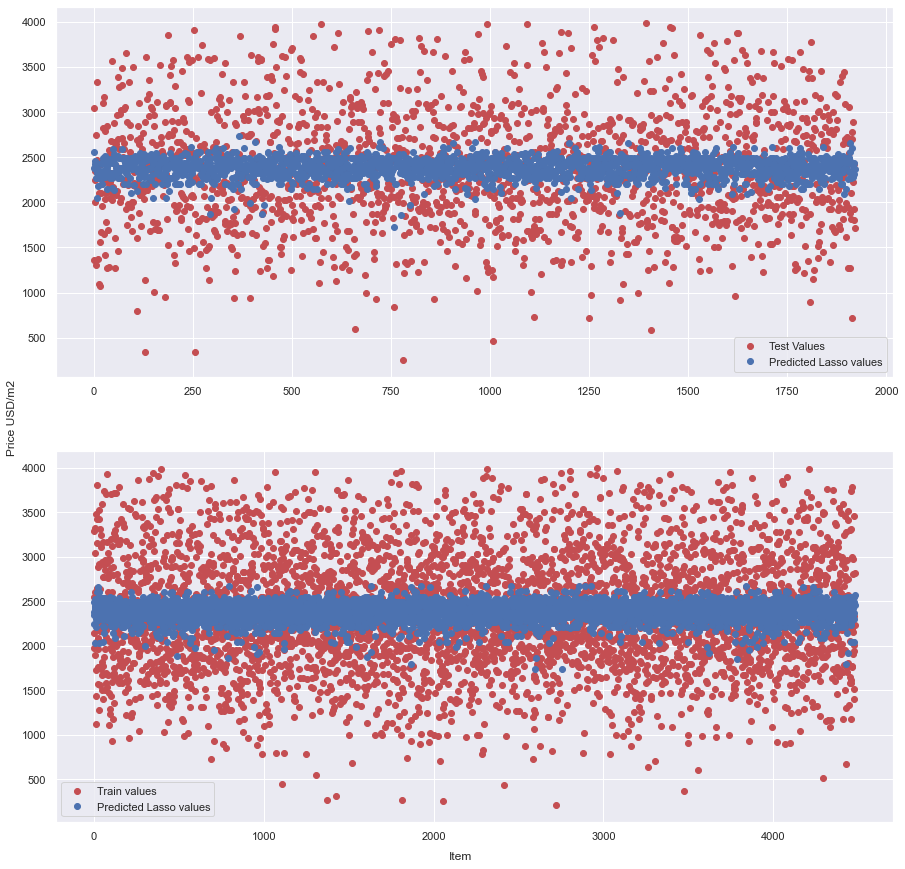

In [108]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],lasso_prediction, 'bo', label="Predicted Lasso values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],lasso_prediction_train, 'bo', label="Predicted Lasso values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Price USD/m2', va='center', rotation='vertical')
plt.show()

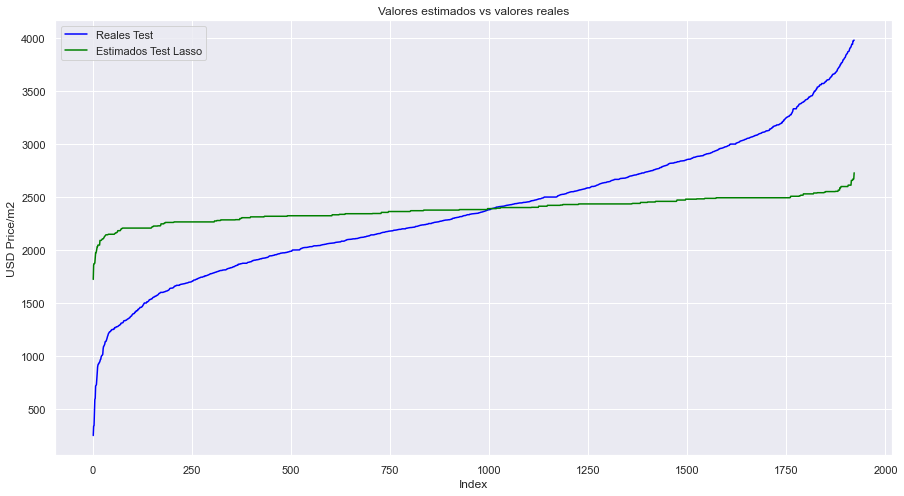

In [109]:
eje_X=range(1,len(y_test)+1)
plt.plot(eje_X, sorted(y_test), color='blue', label='Reales Test')
plt.plot(eje_X, sorted(lasso_prediction), color='green', label='Estimados Test Lasso')
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('USD Price/m2')
plt.show()

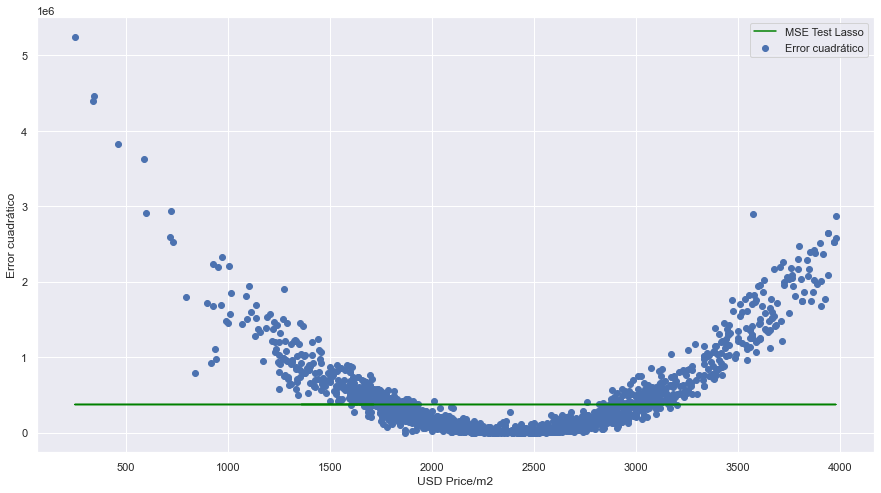

In [110]:
#Qué tan alejados están los valores del error cuadrático medio MSE TEST
err_cuad_test_lasso=pow(y_test - lasso_prediction,2)
plt.scatter(y_test,err_cuad_test_lasso, label='Error cuadrático')
plt.plot(y_test,np.repeat(mse_test_lasso,len(err_cuad_test_lasso)), label='MSE Test Lasso', color='green')
plt.legend()
plt.xlabel('USD Price/m2')
plt.ylabel('Error cuadrático')
plt.show()

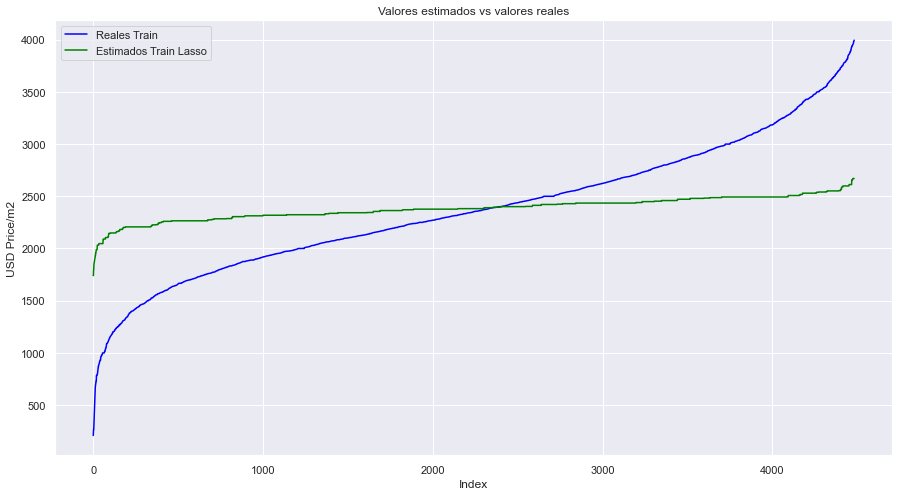

In [111]:
eje_X=range(1,len(y_train)+1)
plt.plot(eje_X, sorted(y_train), color='blue', label='Reales Train')
plt.plot(eje_X, sorted(lasso_prediction_train), color='green', label='Estimados Train Lasso')
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('USD Price/m2')
plt.show()

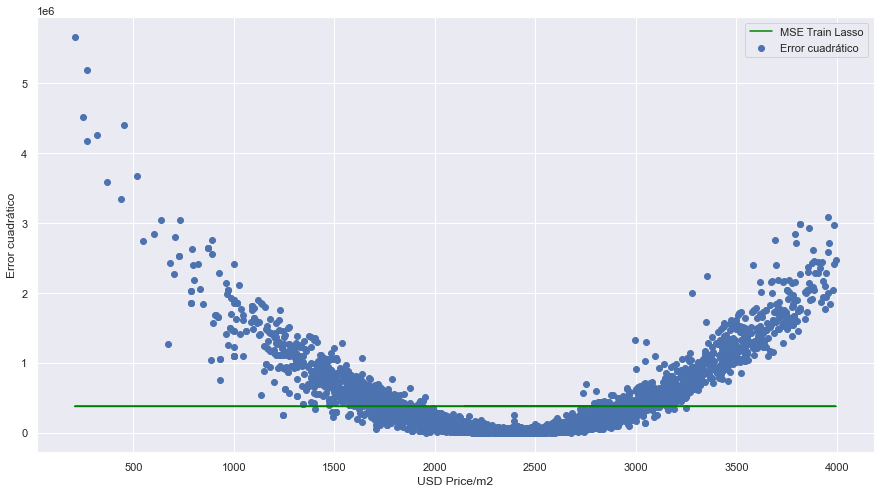

In [112]:
#Qué tan alejados están los valores del error cuadrático medio MSE TRAIN
err_cuad_train_lasso=pow(y_train - lasso_prediction_train,2)
plt.scatter(y_train,err_cuad_train_lasso, label='Error cuadrático')
plt.plot(y_train,np.repeat(mse_train_lasso,len(err_cuad_train_lasso)), label='MSE Train Lasso', color='green')
plt.legend()
plt.xlabel('USD Price/m2')
plt.ylabel('Error cuadrático')
plt.show()

Text(0.5, 1.0, 'Residuos del modelo con train')

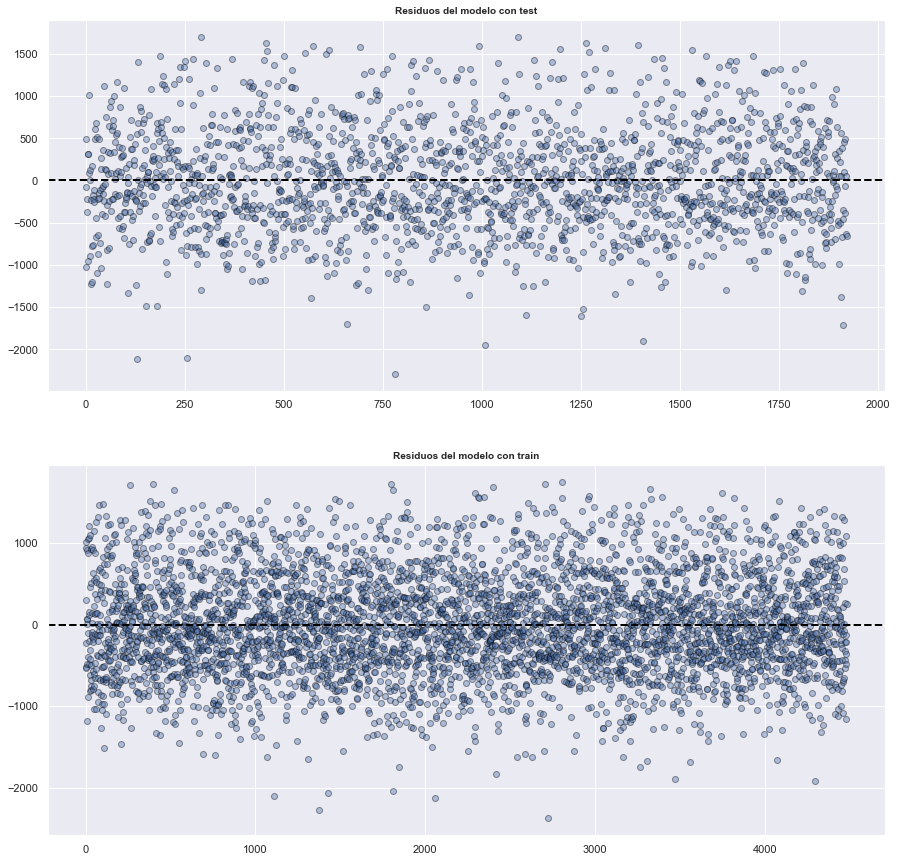

In [113]:
#Gráfico de los residuos/errores
model_residuals_test_lasso = y_test - lasso_prediction
model_residuals_train_lasso = y_train-lasso_prediction_train

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].scatter(list(range(len(y_test))), model_residuals_test_lasso,
                   edgecolors=(0, 0, 0), alpha = 0.4, c="b")
axes[0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0].set_title('Residuos del modelo con test', fontsize = 10, fontweight = "bold")
axes[1].scatter(list(range(len(y_train))), model_residuals_train_lasso,
                   edgecolors=(0, 0, 0), alpha = 0.4, c="b")
axes[1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[1].set_title('Residuos del modelo con train', fontsize = 10, fontweight = "bold")

[Text(0.5, 1.0, 'Residuos con Train')]

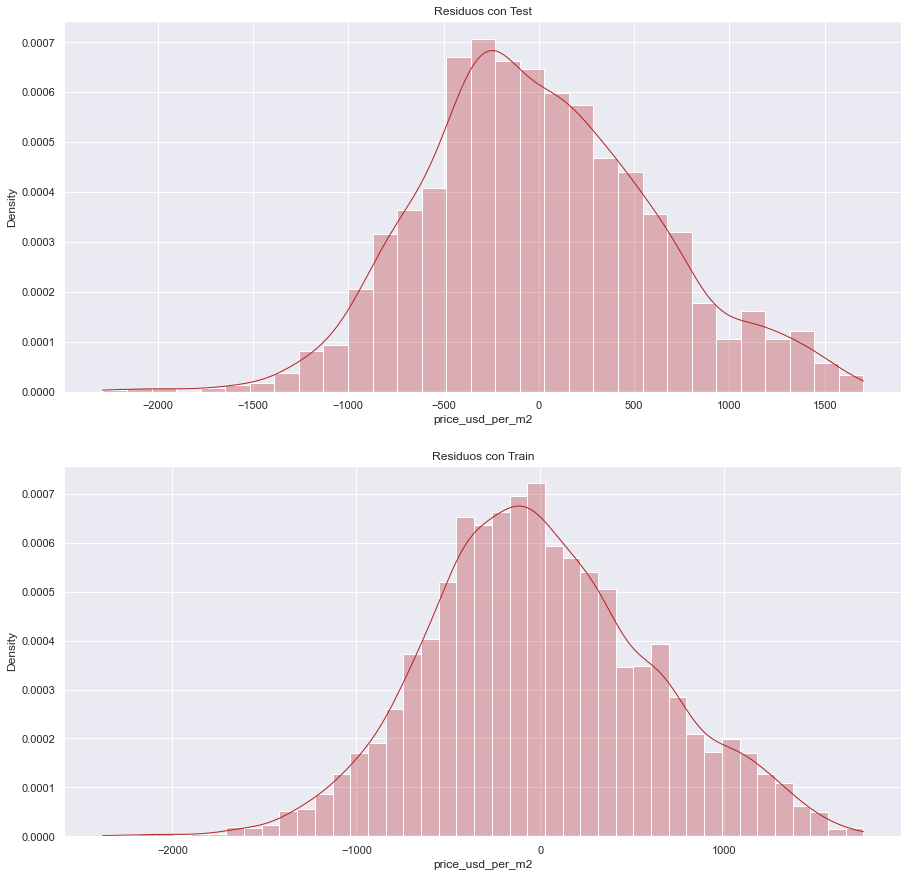

In [114]:
#Histograma de los residuos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

sns.histplot(
    data    = model_residuals_test_lasso,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[0]
).set(title='Residuos con Test')

sns.histplot(
    data    = model_residuals_train_lasso,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1]
).set(title='Residuos con Train')

## Ridge

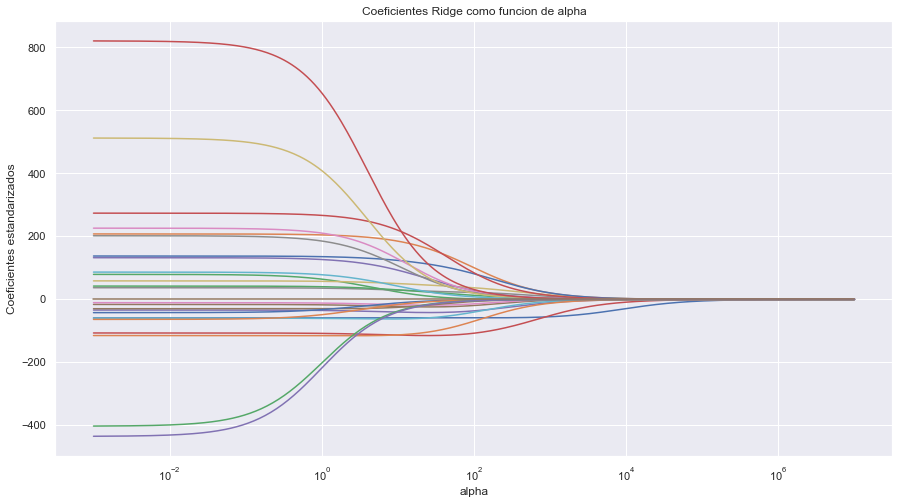

In [115]:
#Análisis previo de los alpha
#alphas_ridge = np.logspace(-10, 10, 400)
alphas_ridge = np.logspace(-3, 7,400)
ridge = linear_model.Ridge(max_iter=10000)
coefs = []

for a in alphas_ridge:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()

ax.plot(alphas_ridge, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coeficientes estandarizados')
plt.title('Coeficientes Ridge como funcion de alpha');

In [116]:
#Creamos el modelo
ridgecv = linear_model.RidgeCV(alphas=alphas_ridge,normalize=False,cv=10)
#Lo entrenamos
model_ridge = ridgecv.fit(X_train, y_train)
#Lo probamos
ridge_prediction = model_ridge.predict(X_test)
ridge_prediction_train = model_ridge.predict(X_train)

alpha_ridge = model_ridge.alpha_
coeff_ridge = model_ridge.coef_
intercept_ridge = model_ridge.intercept_
r2_test_ridge = model_ridge.score(X_test, y_test)
r2_train_ridge = model_ridge.score(X_train, y_train)
p = np.count_nonzero(coeff_ridge)
r2_adj_test_ridge = 1-((1-r2_test_ridge)*((len(y_test)-1)/(len(y_test)-p-1)))
r2_adj_train_ridge = 1-((1-r2_train_ridge)*((len(y_train)-1)/(len(y_train)-p-1)))
mse_test_ridge = mean_squared_error(y_test, ridge_prediction)
mse_train_ridge = mean_squared_error(y_train, ridge_prediction_train)
mae_test_ridge = mean_absolute_error(y_test, ridge_prediction)
mae_train_ridge = mean_absolute_error(y_train, ridge_prediction_train)
rmse_test_ridge = np.sqrt(mse_test_ridge)
rmse_train_ridge = np.sqrt(mse_train_ridge)

#Valores estadísticos MSE Test, MSE Train, MAE Test, MAE Train, RMSE Test, RMSE Train, R2 Test, R2 Train, R2 Adj Test, R2 Adj Train
stats_ridge = [mse_test_ridge, mse_train_ridge,
                mae_test_ridge, mae_train_ridge, 
                rmse_test_ridge,rmse_train_ridge,
                r2_test_ridge,r2_train_ridge,
                r2_adj_test_ridge,r2_adj_train_ridge
                ]

stats_dataframe_ridge =pd.DataFrame({name_model+' Ridge':stats_ridge},index=['MSE Test', 'MSE Train', 'MAE Test', 'MAE Train', 'RMSE Test', 'RMSE Train', 'R2 Test','R2 Train', 'R2 Adj Test','R2 Adj Train'])
stats_dataframe_ridge

Modelo 1 Ridge
MSE Test       371349.859062
MSE Train      374675.566815
MAE Test          485.866628
MAE Train         486.725001
RMSE Test         609.384820
RMSE Train        612.107480
R2 Test             0.029131
R2 Train            0.035153
R2 Adj Test         0.016322
R2 Adj Train        0.029738

In [117]:
print("Alpha Ridge:",alpha_ridge)
print("Intercept Ridge:",intercept_ridge)
print("Coeficientes Ridge:")
print(pd.Series(coeff_ridge, index=X.columns))

Alpha Ridge: 32.454744574113256
Intercept Ridge: 2402.2837969378984
Coeficientes Ridge:
rooms              -58.407483
ptype_apartment    151.833304
ptype_house          7.705298
floor_1.0         -114.731522
floor_2.0          -41.758483
floor_3.0          -23.914443
floor_4.0          -18.397449
floor_5.0           25.181414
floor_6.0           43.992103
floor_7.0          -56.690792
floor_8.0          107.687803
floor_9.0          -99.370667
floor_10.0          21.158816
floor_11.0         155.528984
floor_12.0          57.333277
floor_13.0         -15.880085
floor_14.0          64.661055
floor_15.0          52.164134
floor_16.0          55.292456
floor_17.0          19.794884
floor_18.0          -4.320084
floor_20.0          -6.151795
floor_21.0         -12.305625
floor_22.0          89.066265
floor_23.0         -13.275009
floor_24.0           0.000000
dtype: float64


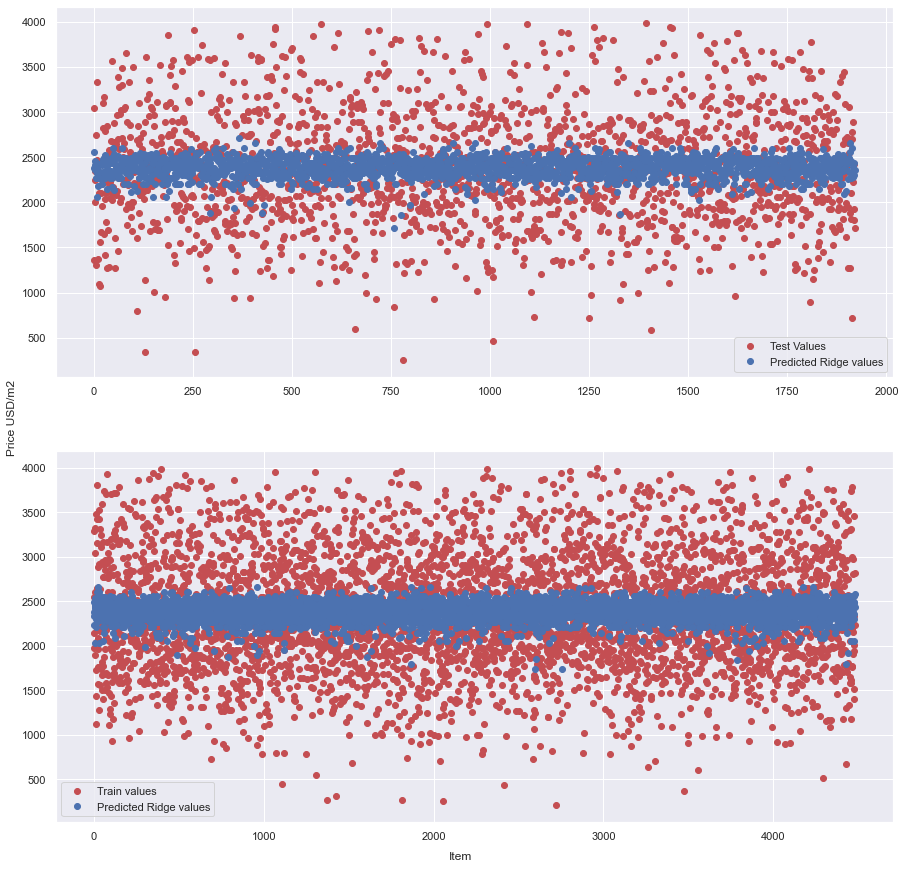

In [118]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],ridge_prediction, 'bo', label="Predicted Ridge values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],ridge_prediction_train, 'bo', label="Predicted Ridge values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Price USD/m2', va='center', rotation='vertical')
plt.show()

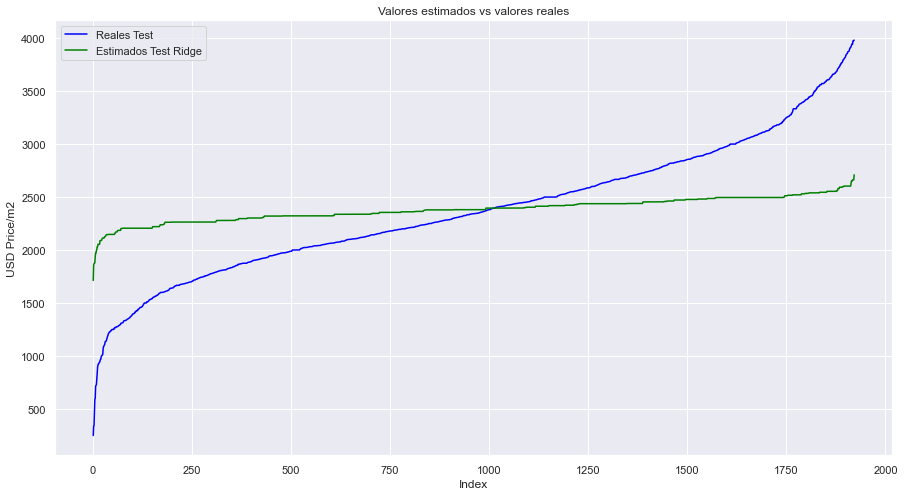

In [119]:
eje_X=range(1,len(y_test)+1)
plt.plot(eje_X, sorted(y_test), color='blue', label='Reales Test')
plt.plot(eje_X, sorted(ridge_prediction), color='green', label='Estimados Test Ridge')
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('USD Price/m2')
plt.show()

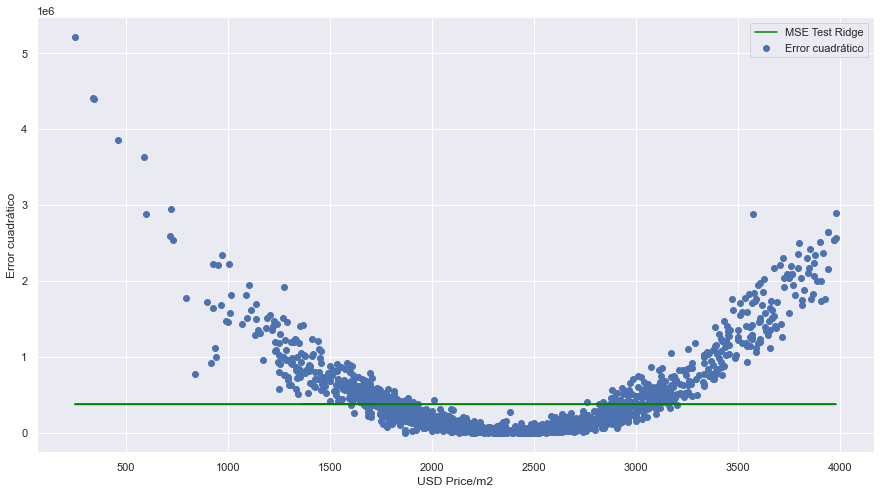

In [120]:
#Qué tan alejados están los valores del error cuadrático medio MSE TEST
err_cuad_test_ridge=pow(y_test - ridge_prediction,2)
plt.scatter(y_test,err_cuad_test_ridge, label='Error cuadrático')
plt.plot(y_test,np.repeat(mse_test_ridge,len(err_cuad_test_ridge)), label='MSE Test Ridge', color='green')
plt.legend()
plt.xlabel('USD Price/m2')
plt.ylabel('Error cuadrático')
plt.show()

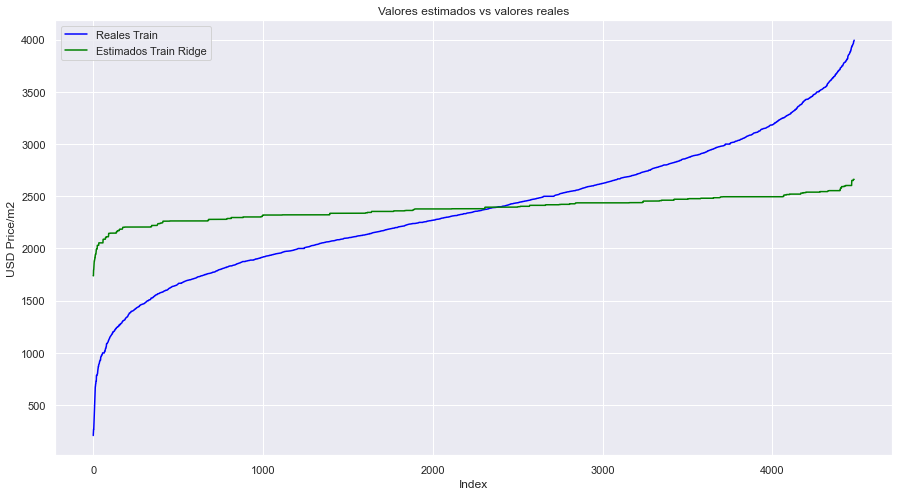

In [121]:
eje_X=range(1,len(y_train)+1)
plt.plot(eje_X, sorted(y_train), color='blue', label='Reales Train')
plt.plot(eje_X, sorted(ridge_prediction_train), color='green', label='Estimados Train Ridge')
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('USD Price/m2')
plt.show()

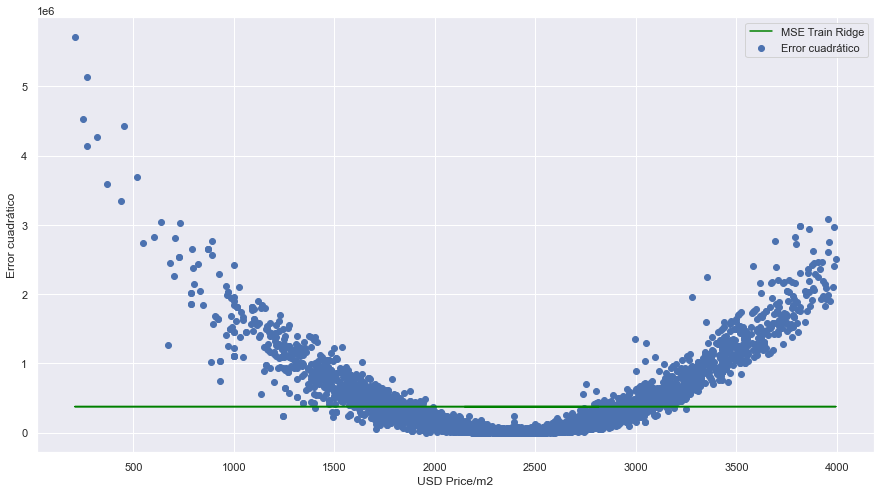

In [122]:
#Qué tan alejados están los valores del error cuadrático medio MSE TRAIN
err_cuad_train_ridge=pow(y_train - ridge_prediction_train,2)
plt.scatter(y_train,err_cuad_train_ridge, label='Error cuadrático')
plt.plot(y_train,np.repeat(mse_train_ridge,len(err_cuad_train_ridge)), label='MSE Train Ridge', color='green')
plt.legend()
plt.xlabel('USD Price/m2')
plt.ylabel('Error cuadrático')
plt.show()

Text(0.5, 1.0, 'Residuos del modelo con train')

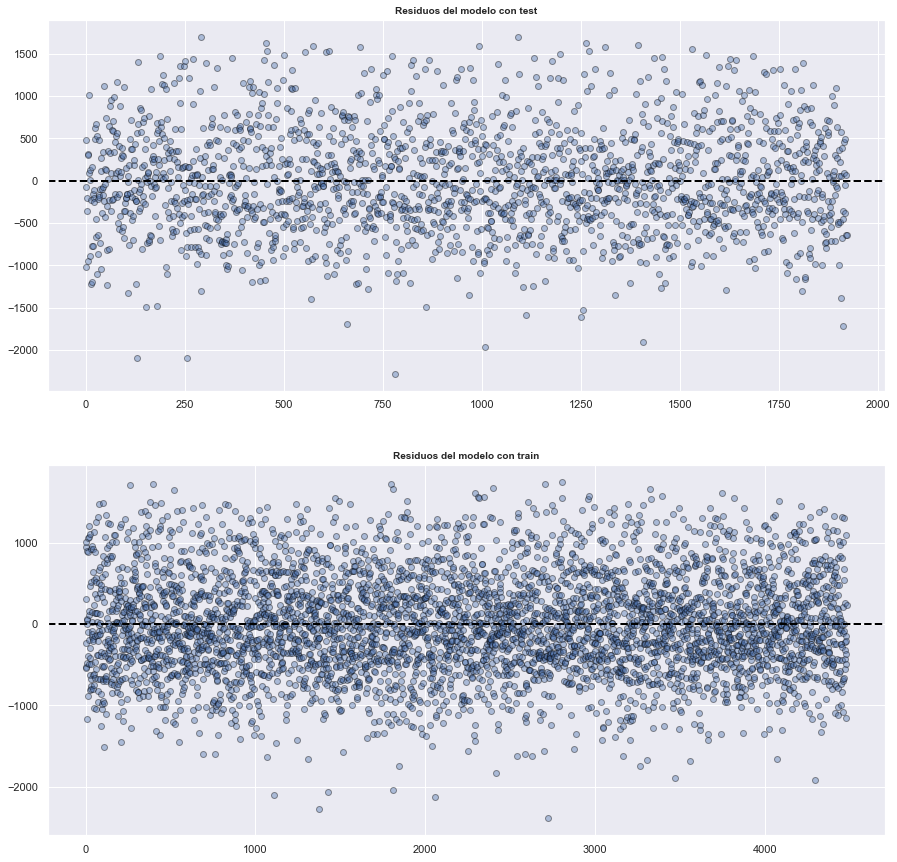

In [123]:
#Gráfico de los residuos/errores
model_residuals_test_ridge = y_test - ridge_prediction
model_residuals_train_ridge = y_train-ridge_prediction_train

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].scatter(list(range(len(y_test))), model_residuals_test_ridge,
                   edgecolors=(0, 0, 0), alpha = 0.4, c="b")
axes[0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0].set_title('Residuos del modelo con test', fontsize = 10, fontweight = "bold")
axes[1].scatter(list(range(len(y_train))), model_residuals_train_ridge,
                   edgecolors=(0, 0, 0), alpha = 0.4, c="b")
axes[1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[1].set_title('Residuos del modelo con train', fontsize = 10, fontweight = "bold")

[Text(0.5, 1.0, 'Residuos con Train')]

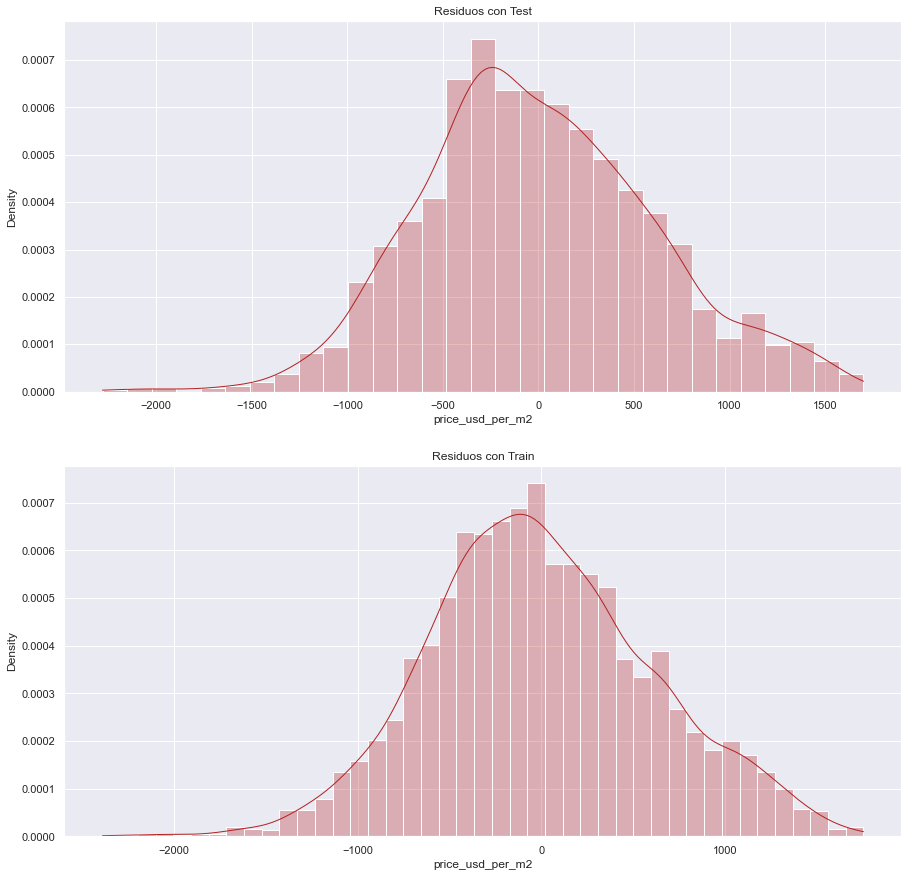

In [124]:
#Histograma de los residuos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

sns.histplot(
    data    = model_residuals_test_ridge,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[0]
).set(title='Residuos con Test')

sns.histplot(
    data    = model_residuals_train_ridge,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1]
).set(title='Residuos con Train')

----
## Modelos comparados entre sí

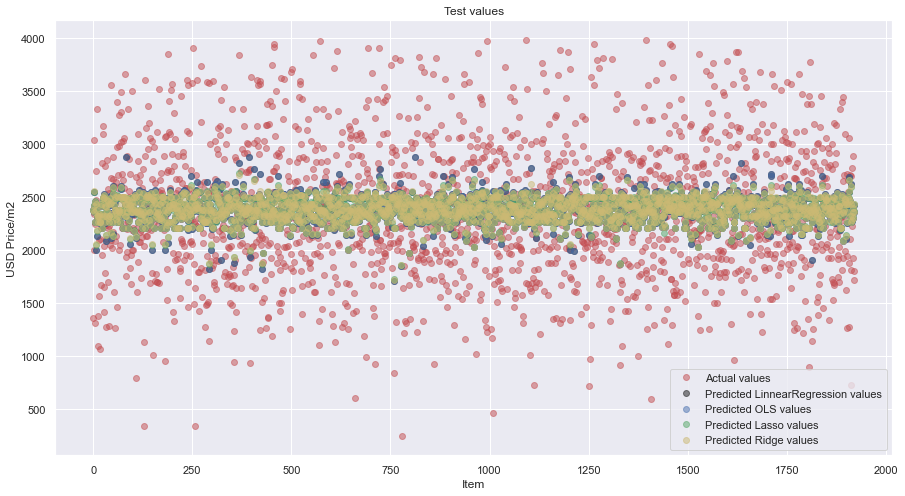

In [125]:
plt.figure(figsize=(15, 8))

plt.plot([i for i in range(len(y_test))],y_test, 'ro',label="Actual values",alpha=0.5)
plt.plot([i for i in range(len(y_test))],lr_prediction, 'ko',label="Predicted LinnearRegression values",alpha=0.5)
plt.plot([i for i in range(len(y_test))],sm_prediction, 'bo', label="Predicted OLS values",alpha=0.5)
plt.plot([i for i in range(len(y_test))],lasso_prediction, 'go', label="Predicted Lasso values",alpha=0.5)
plt.plot([i for i in range(len(y_test))],ridge_prediction, 'yo', label="Predicted Ridge values",alpha=0.5)

plt.legend()
plt.ylabel('USD Price/m2')
plt.xlabel('Item')
plt.title("Test values")
plt.show()

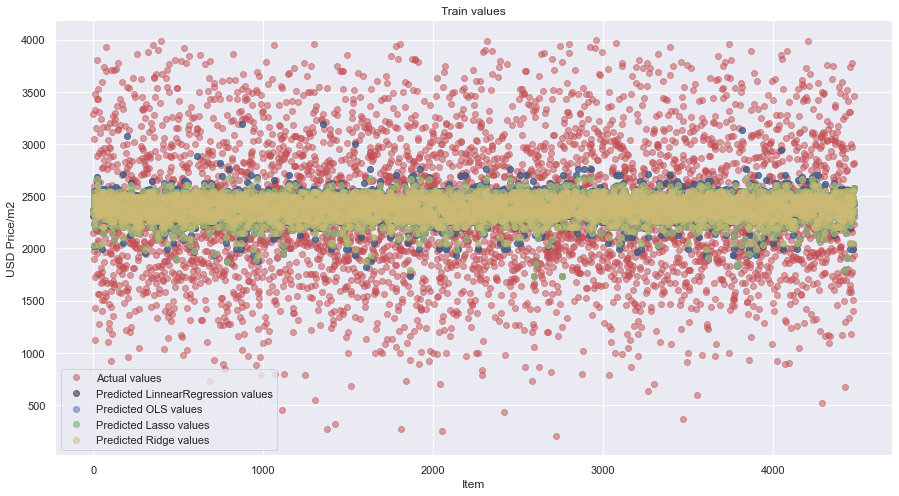

In [126]:
plt.figure(figsize=(15, 8))

plt.plot([i for i in range(len(y_train))],y_train, 'ro',label="Actual values",alpha=0.5)
plt.plot([i for i in range(len(y_train))],lr_prediction_train, 'ko',label="Predicted LinnearRegression values",alpha=0.5)
plt.plot([i for i in range(len(y_train))],sm_prediction_train, 'bo', label="Predicted OLS values",alpha=0.5)
plt.plot([i for i in range(len(y_train))],lasso_prediction_train, 'go', label="Predicted Lasso values",alpha=0.5)
plt.plot([i for i in range(len(y_train))],ridge_prediction_train, 'yo', label="Predicted Ridge values",alpha=0.5)

plt.legend()
plt.ylabel('USD Price/m2')
plt.xlabel('Item')
plt.title("Train values")
plt.show()

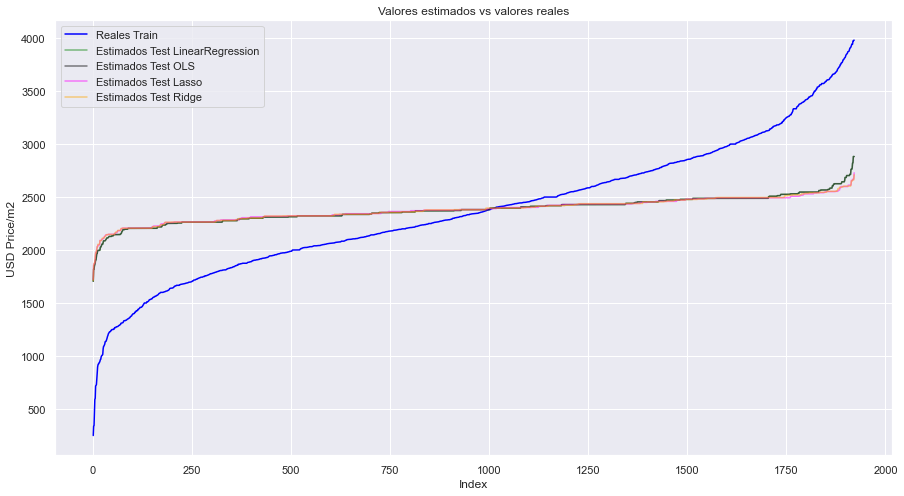

In [127]:
eje_X=range(1,len(y_test)+1)
plt.plot(eje_X, sorted(y_test), color='blue', label='Reales Train')
plt.plot(eje_X, sorted(lr_prediction), color='green', label='Estimados Test LinearRegression', alpha=0.5)
plt.plot(eje_X, sorted(sm_prediction), color='black', label='Estimados Test OLS', alpha=0.5)
plt.plot(eje_X, sorted(lasso_prediction), color='magenta', label='Estimados Test Lasso', alpha=0.5)
plt.plot(eje_X, sorted(ridge_prediction), color='orange', label='Estimados Test Ridge', alpha=0.5)
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('USD Price/m2')
plt.show()

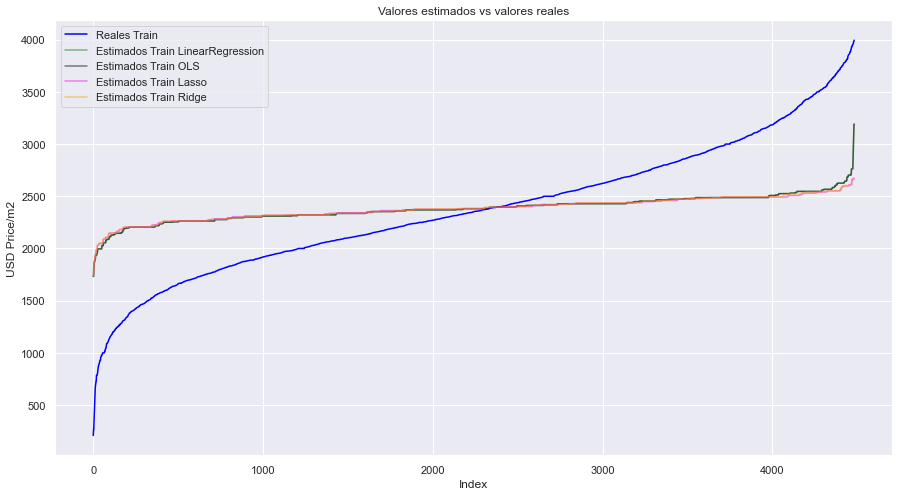

In [128]:
eje_X=range(1,len(y_train)+1)
plt.plot(eje_X, sorted(y_train), color='blue', label='Reales Train')
plt.plot(eje_X, sorted(lr_prediction_train), color='green', label='Estimados Train LinearRegression', alpha=0.5)
plt.plot(eje_X, sorted(sm_prediction_train), color='black', label='Estimados Train OLS', alpha=0.5)
plt.plot(eje_X, sorted(lasso_prediction_train), color='magenta', label='Estimados Train Lasso', alpha=0.5)
plt.plot(eje_X, sorted(ridge_prediction_train), color='orange', label='Estimados Train Ridge', alpha=0.5)
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('USD Price/m2')
plt.show()

In [129]:
# Valores estadísticos
pd.concat([stats_dataframe_lr,stats_dataframe_ols,stats_dataframe_lasso,stats_dataframe_ridge],axis=1)

Modelo 1 LR   Modelo 1 OLS  Modelo 1 Lasso  Modelo 1 Ridge
MSE Test      371723.501230  371723.501230   371785.102650   371349.859062
MSE Train     373533.040781  373533.040781   375106.673264   374675.566815
MAE Test         485.846900     485.846900      486.196129      485.866628
MAE Train        485.676851     485.676851      487.126322      486.725001
RMSE Test        609.691316     609.691316      609.741833      609.384820
RMSE Train       611.173495     611.173495      612.459528      612.107480
R2 Test            0.028154       0.028154        0.027993        0.029131
R2 Train           0.038095       0.038095        0.034043        0.035153
R2 Adj Test        0.015333       0.032129        0.021880        0.016322
R2 Adj Train       0.032697       0.032697        0.031448        0.029738

In [130]:
# Parámetros
index_series = np.insert(X.columns.to_numpy(),0,'intercept')
series_lr = pd.Series(np.insert(coeff_lr,0,model_lr.intercept_),index=index_series, name="Linear Regression")
series_ols = pd.Series(model_ols.params.to_numpy(),index=index_series, name="OLS")
series_lasso = pd.Series(np.insert(coeff_lasso,0,model_lasso.intercept_),index=index_series, name="Lasso")
series_ridge = pd.Series(np.insert(coeff_ridge,0,model_ridge.intercept_),index=index_series, name="Lasso")

pd.concat([series_lr,series_ols,series_lasso,series_ridge],axis=1)

Linear Regression          OLS        Lasso        Lasso
intercept              2339.289990  2339.289990  2391.325435  2402.283797
rooms                   -59.029881   -59.029881   -58.256886   -58.407483
ptype_apartment         207.820572   207.820572   160.201780   151.833304
ptype_house              79.368112    79.368112     0.000000     7.705298
floor_1.0              -106.701721  -106.701721  -111.550561  -114.731522
floor_2.0               -33.910793   -33.910793   -34.085155   -41.758483
floor_3.0               -16.074098   -16.074098   -13.405520   -23.914443
floor_4.0               -10.451997   -10.451997    -5.589240   -18.397449
floor_5.0                37.007355    37.007355    14.006275    25.181414
floor_6.0                58.730653    58.730653    36.628409    43.992103
floor_7.0               -59.670158   -59.670158   -40.090914   -56.690792
floor_8.0               137.692949   137.692949   105.954238   107.687803
floor_9.0              -114.884109  -114.884109   -90.247614   -99.370667
floor_10.0               42.223851    42.223851     0.000000    21.158816
floor_11.0              273.863706   273.863706   177.208381   155.528984
floor_12.0              132.350700   132.350700     0.000000    57.333277
floor_13.0              -29.684963   -29.684963    -0.000000   -15.880085
floor_14.0              226.177828   226.177828     0.000000    64.661055
floor_15.0              202.015270   202.015270     0.000000    52.164134
floor_16.0              512.480623   512.480623     0.000000    55.292456
floor_17.0               86.619411    86.619411     0.000000    19.794884
floor_18.0              -42.182091   -42.182091    -0.000000    -4.320084
floor_20.0              -63.622245   -63.622245    -0.000000    -6.151795
floor_21.0             -402.807804  -402.807804    -0.000000   -12.305625
floor_22.0              821.062513   821.062513     0.000000    89.066265
floor_23.0             -435.238310  -435.238310    -0.000000   -13.275009
floor_24.0                0.000000     0.000000     0.000000     0.000000